In [ ]:
!pip install -q -U tensorflow>=1.8.0
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import os, time

**Load Dataset**

In [ ]:
dataset = np.load('fashion_mnist_dataset_train.npy', allow_pickle=True).item()

In [ ]:
X = dataset['features']
y = dataset['target']

In [ ]:
X.shape, y.shape

((60000, 28, 28), (60000,))

In [ ]:
y

array([5., 2., 1., ..., 3., 1., 4.])

In [ ]:
y = y-1

In [ ]:
y

array([4., 1., 0., ..., 2., 0., 3.])

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 5)

In [ ]:
y

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
y.shape

(60000, 5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
# train - val - test split (80%-10%-10% , random seed =0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [ ]:
X_train.shape, y_train.shape

((48000, 28, 28), (48000, 5))

In [ ]:
X_train = tf.expand_dims(X_train, axis=-1)
X_val = tf.expand_dims(X_val, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

(TensorShape([48000, 28, 28, 1]),
 TensorShape([6000, 28, 28, 1]),
 TensorShape([6000, 28, 28, 1]))

**Transfer Learning ResNet50**

In [ ]:
# Resize the images 32*32 as required by ResNet50
# pad zeros to make 28*28*1 array to 32*32*3 array
X_train = np.pad(X_train,((0,0),(2,2),(2,2),(1,1)), mode='constant', constant_values=0)
X_val = np.pad(X_val,((0,0),(2,2),(2,2),(1,1)), mode='constant', constant_values=0)
X_test = np.pad(X_test,((0,0),(2,2),(2,2),(1,1)), mode='constant', constant_values=0)

X_train.shape, X_val.shape, X_test.shape

((48000, 32, 32, 3), (6000, 32, 32, 3), (6000, 32, 32, 3))

In [ ]:
IMAGE_SIZE = [32, 32,3]
NUM_CLASSES = 5

# add preprocessing layer to the front of Resnet
resnet = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
# don't train existing weights(Freeze the base model)
for layer in resnet.layers:
  layer.trainable = False

# adding flatten and output layer to the resnet architecture
x = Flatten()(resnet.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer= Adam(),
             metrics=['accuracy'])

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

**Train Model**

In [ ]:
# Train the the model
start_time = time.time()

train_model = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val))

end_time = time.time()
resnet_time = end_time - start_time
print("Total training time is {:0.2f} minute".format(resnet_time/60.0))

Epoch 1/50
375/375 [==============================] - 46s 28ms/step - loss: 1.5656 - accuracy: 0.4061 - val_loss: 1.0754 - val_accuracy: 0.5980
Epoch 2/50
375/375 [==============================] - 9s 23ms/step - loss: 1.0306 - accuracy: 0.6245 - val_loss: 0.9519 - val_accuracy: 0.6475
Epoch 3/50
375/375 [==============================] - 9s 23ms/step - loss: 0.9359 - accuracy: 0.6522 - val_loss: 0.9023 - val_accuracy: 0.6533
Epoch 4/50
375/375 [==============================] - 9s 23ms/step - loss: 0.8873 - accuracy: 0.6617 - val_loss: 0.8746 - val_accuracy: 0.6665
Epoch 5/50
375/375 [==============================] - 9s 23ms/step - loss: 0.8512 - accuracy: 0.6727 - val_loss: 0.8492 - val_accuracy: 0.6583
Epoch 6/50
375/375 [==============================] - 9s 24ms/step - loss: 0.8258 - accuracy: 0.6836 - val_loss: 0.8292 - val_accuracy: 0.6747
Epoch 7/50
375/375 [==============================] - 9s 23ms/step - loss: 0.8082 - accuracy: 0.6856 - val_loss: 0.7972 - val_accuracy: 0.682

**Test Accuracy**

In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.6460675597190857
Train accuracy: 0.7398333549499512


In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.6525036096572876
Val accuracy: 0.7350000143051147


In [ ]:
%%time
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6484851241111755
Test accuracy: 0.7443333268165588
CPU times: user 2.07 s, sys: 84.7 ms, total: 2.15 s
Wall time: 2.2 s


**Accuracy-Loss Plots**

In [ ]:
def accuracy_loss_plot(model):

  hist = model.history
  acc = hist['accuracy']
  val_acc = hist['val_accuracy']
  loss = hist['loss']
  val_loss = hist['val_loss']
  epoch = range(50)

  fig = plt.figure(figsize = (12,10))
  plt.subplot(2,2,1)
  sns.lineplot(acc,loss)
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.legend(['train set'], loc='upper right')
  plt.title('Training Accuracy vs Loss')

  plt.subplot(2,2,2)
  sns.lineplot(val_acc,val_loss)
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.legend(['validation set'], loc='upper right')
  plt.title('Validation Accuracy vs Loss')

  plt.subplot(2,2,3)
  sns.lineplot(epoch, acc)
  sns.lineplot(epoch, val_acc)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['train set', 'validation set'], loc='lower right')
  plt.title('Accuracy vs Epoch')

  plt.subplot(2,2,4)
  sns.lineplot(epoch, loss)
  sns.lineplot(epoch, val_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train set', 'validation set'], loc='upper right')
  plt.title('Loss vs Epoch')

  plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

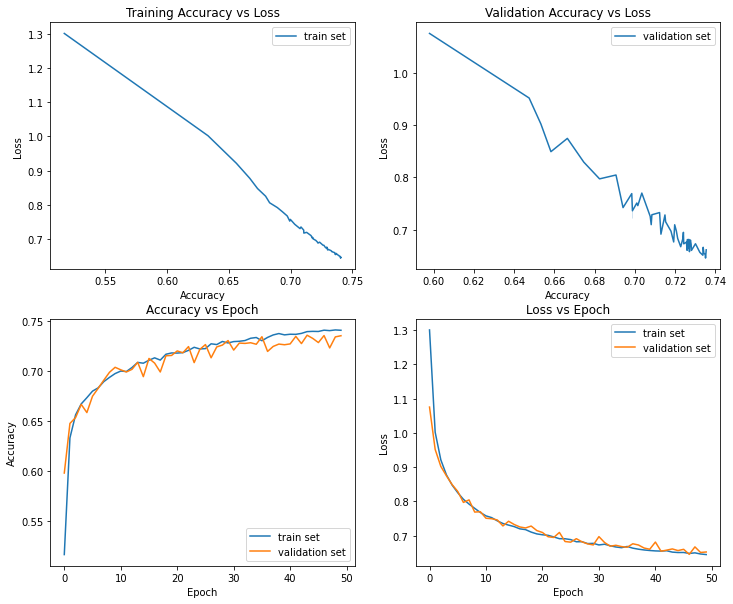

In [ ]:
accuracy_loss_plot(train_model)